In [1]:
#!pip install textblob

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from textblob import TextBlob

In [4]:
# Load the CSV files
amazon_data = pd.read_csv('amazon.csv')
netflix_data = pd.read_csv('netflix_titles.csv')

In [5]:
amazon_data['discounted_price'] = amazon_data['discounted_price'].replace('[₹,]', '', regex=True).astype(float)
amazon_data['actual_price'] = amazon_data['actual_price'].replace('[₹,]', '', regex=True).astype(float)

In [6]:
# Cleaning the rating column
amazon_data['rating'] = pd.to_numeric(amazon_data['rating'], errors='coerce')

In [7]:
# Cleaning the rating_count column by removing commas and converting to numeric
amazon_data['rating_count'] = amazon_data['rating_count'].replace(',', '', regex=True).astype(float)

In [8]:
# Top categories based on the count of products
amazon_data['category'] = amazon_data['category'].str.split('|').str[0]  # Extract main category
top_categories = amazon_data['category'].value_counts().head(5)
print("Top 5 Categories:\n", top_categories)

Top 5 Categories:
 category
Electronics              526
Computers&Accessories    453
Home&Kitchen             448
OfficeProducts            31
MusicalInstruments         2
Name: count, dtype: int64


In [9]:
# Products with the highest discounts
top_discounts = amazon_data.sort_values('discount_percentage', ascending=False)[['product_name', 'discount_percentage']].head(5)
print("\nTop 5 Products with Highest Discounts:\n", top_discounts)


Top 5 Products with Highest Discounts:
                                           product_name discount_percentage
695  rts [2 Pack] Mini USB C Type C Adapter Plug, T...                 94%
364  Fire-Boltt Ninja Call Pro Plus 1.83" Smart Wat...                 91%
380  Fire-Boltt Ninja Call Pro Plus 1.83" Smart Wat...                 91%
368  Fire-Boltt Ninja Call Pro Plus 1.83" Smart Wat...                 91%
334  Fire-Boltt Ninja Call Pro Plus 1.83" Smart Wat...                 91%


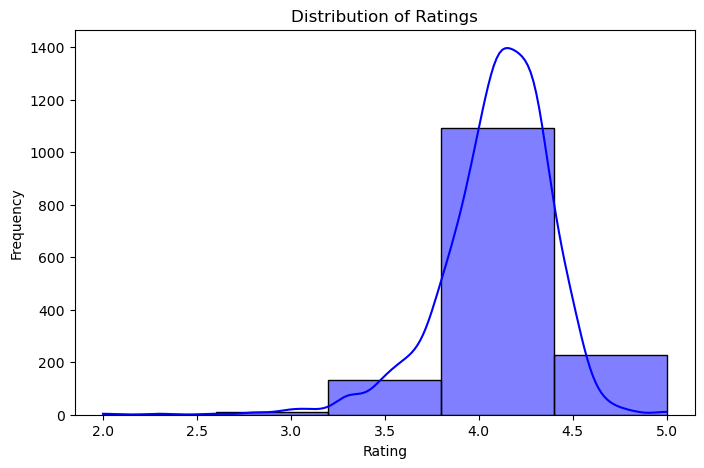

In [10]:
# Visualization: Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.histplot(amazon_data['rating'], bins=5, kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Sentiment Analysis on Amazon Reviews
def analyze_sentiment(review):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [12]:
# Drop rows with missing values in the relevant columns to maintain consistency
amazon_data_cleaned = amazon_data.dropna(subset=['discounted_price', 'actual_price', 'rating', 'rating_count'])

In [13]:
amazon_data['review_sentiment'] = amazon_data['review_content'].apply(analyze_sentiment)
sentiment_counts = amazon_data['review_sentiment'].value_counts()
print("\nAmazon Review Sentiments:\n", sentiment_counts)


Amazon Review Sentiments:
 review_sentiment
Positive    1438
Negative      26
Neutral        1
Name: count, dtype: int64


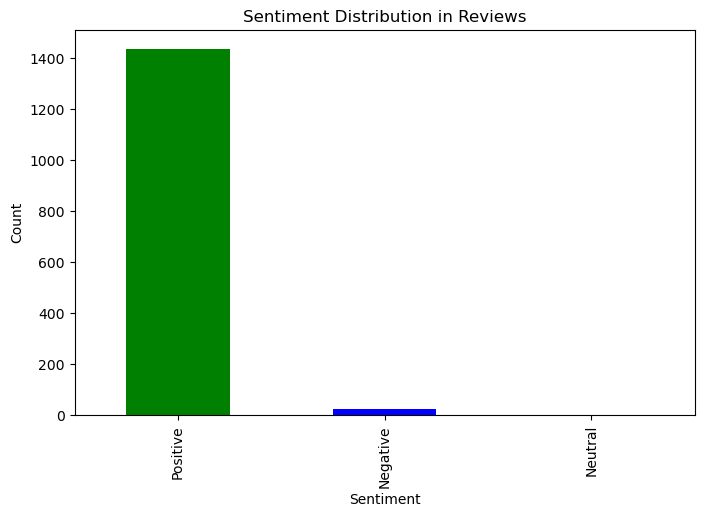

In [14]:
# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution in Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [15]:
# Selecting features for clustering
features = amazon_data_cleaned[['discounted_price', 'actual_price', 'rating', 'rating_count']]

In [16]:
# Scaling the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [17]:
# Clustering with K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
amazon_data_cleaned['cluster'] = kmeans.fit_predict(scaled_features)

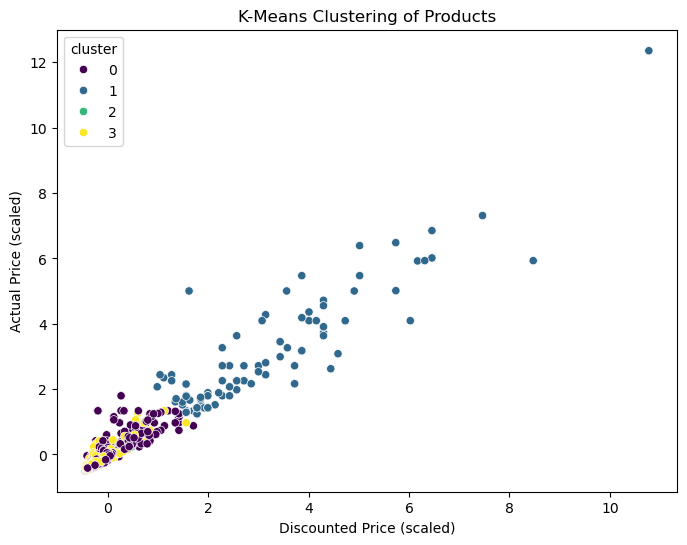

In [18]:
# Visualizing the clusters using the first two features (PCA is optional for more dimensions)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=amazon_data_cleaned['cluster'], palette='viridis')
plt.title('K-Means Clustering of Products')
plt.xlabel('Discounted Price (scaled)')
plt.ylabel('Actual Price (scaled)')
plt.show()

In [19]:
# Output clustered data summary
print("\nCluster Summary:")
amazon_data_cleaned.groupby('cluster').count()


Cluster Summary:


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
cluster,,,,,,,,,,,,,,,,
0,972,972,972,972,972,972,972,972,972,972,972,972,972,972,972,972
1,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103
2,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
3,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345


In [20]:
# Top genres based on their count
netflix_data['listed_in'] = netflix_data['listed_in'].str.split(', ')
genres = netflix_data['listed_in'].explode()
top_genres = genres.value_counts().head(5)
print("Top 5 Genres:\n", top_genres)

Top 5 Genres:
 listed_in
International Movies      2752
Dramas                    2427
Comedies                  1674
International TV Shows    1351
Documentaries              869
Name: count, dtype: int64


In [21]:
# Number of movies vs TV shows
content_type_count = netflix_data['type'].value_counts()
print("\nContent Types Count:\n", content_type_count)


Content Types Count:
 type
Movie      6131
TV Show    2676
Name: count, dtype: int64


In [22]:
# Movies with the highest duration
movies = netflix_data[netflix_data['type'] == 'Movie']
movies['duration'] = movies['duration'].str.replace(' min', '').astype(float)
longest_movies = movies.sort_values('duration', ascending=False).head(5)
print("\nTop 5 Longest Movies:\n", longest_movies[['title', 'duration']])


Top 5 Longest Movies:
                             title  duration
4253   Black Mirror: Bandersnatch     312.0
717   Headspace: Unwind Your Mind     273.0
2491       The School of Mischief     253.0
2487               No Longer kids     237.0
2484           Lock Your Girls In     233.0


In [23]:
netflix_data['listed_in'] = netflix_data['listed_in'].apply(lambda x: ' '.join(x.split(',')) if isinstance(x, str) else ' '.join(x))

In [24]:
# Content-Based Recommendation System
tfidf = TfidfVectorizer(stop_words='english')
netflix_data['description'] = netflix_data['description'].fillna('')
tfidf_matrix = tfidf.fit_transform(netflix_data['description'])

In [25]:
# K-Means Clustering for Genres
genres_matrix = tfidf.fit_transform(netflix_data['listed_in'].apply(lambda x: ' '.join(x.split(','))))
kmeans = KMeans(n_clusters=4, random_state=42)
netflix_data['genre_cluster'] = kmeans.fit_predict(genres_matrix)

In [26]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(genres_matrix.toarray())

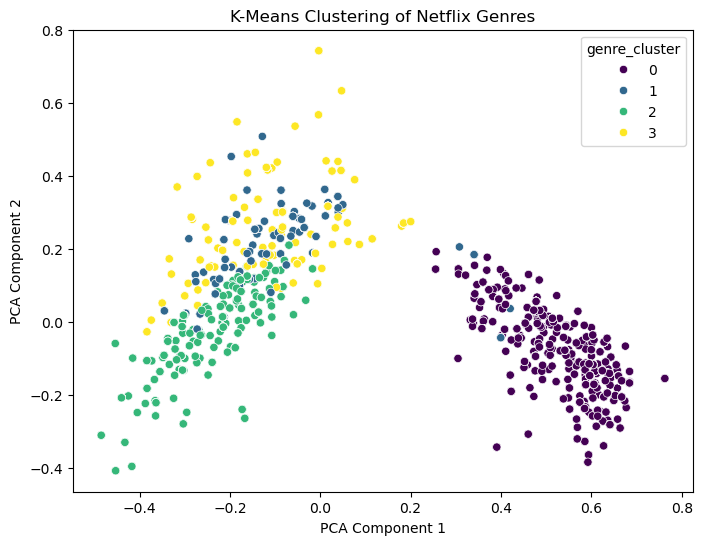

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=netflix_data['genre_cluster'], palette='viridis')
plt.title('K-Means Clustering of Netflix Genres')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [28]:
# Output cluster summary
print("\nCluster Summary by Genre:")
print(netflix_data.groupby('genre_cluster')['title'].count())


Cluster Summary by Genre:
genre_cluster
0    2556
1     874
2    3307
3    2070
Name: title, dtype: int64
